In [1]:
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
import glob as glob
import re
import string
import numpy as np
import pandas as pd
import json
# re.sub(f"[{re.escape(string.punctuation)}]", " ", testo)

In [3]:
import spacy

In [4]:
spacy.__version__

'3.0.3'

In [5]:
nlp = spacy.load("it_core_news_sm")

frase_esempio = "Mi piace New York"

doc = nlp(frase_esempio)

for n, token in enumerate(doc):
    print(f"{n+1}) {token}")

1) Mi
2) piace
3) New
4) York


In [6]:
nlp.add_pipe("merge_entities")

doc = nlp(frase_esempio)

for n, token in enumerate(doc):
    print(f"{n+1}) {token}")

1) Mi
2) piace
3) New York


## Generator articoli

In [7]:
articoli = iter(glob.glob("archivio/*.txt"))

In [8]:
next(articoli)

'archivio/articolo_tecnologia_69.txt'

##### La keywords identifica la classe dal nome del file, sarà quindi eliminata dal testo per rendere più difficile il lavoro al classificatore.

In [9]:
keywords = re.compile(r"_(\w+)_")

###### Anteprima file

In [10]:
articolo = next(articoli)

with open(articolo, 'r') as f:
    testo = f.readlines()
    testo = "".join(testo)

print(testo[:100])
print("-"*100)
print(testo[-100:])

<article><title>Potenza Calcio</title><body>Il Potenza Calcio S.r.l., meglio noto come Potenza, è un
----------------------------------------------------------------------------------------------------
'Internet Archive", 'Categoria:Voci con modulo citazione e parametro pagine']</categories></article>


##### Altra regular expression per estrarre i dati in formato dictionary

In [11]:
tags = re.compile(r"<title>(?P<titolo>.*)</title><body>(?P<corpo>.*)</body><categories>(?P<categorie>.*)</categories>")

##### Qui la funzione che estrae i dati e fa un primo preprocessing

In [12]:
def estrati_dati(articolo):
    
    # Identificazione della class/keywords estraendola dal nome del file
    kw = keywords.findall(articolo)[0]

    with open(articolo, 'r') as f:
        testo = f.readlines()
        
    testo = "".join(testo)
    testo = testo.replace("\n","")
    
    # Estrazione dei campi di interesse per ottenere il dictionary
    m = tags.search(testo)
    dati = m.groupdict()
    
    if 'categorie' in dati.keys():

        get_text = re.compile("\'|\\[|\\]|Categoria:")

        categorie = m.group('categorie')
        elenco_categorie = []

        for categ in get_text.sub("", categorie).split(","):
            elenco_categorie.append(categ.strip())

        dati['categorie'] = ",".join(elenco_categorie)
    
    # Rimozione della keyword, che rappresenta la classe, per aumentare 
    # la capacità di generalizzare del classificatore
    remove_kw = re.compile(fr"\b{kw}\b")

    testo = " ".join([txt.lower() for k, txt in dati.items()])
    testo = re.sub("\W|\d", " ", testo)
    testo = re.sub("[ ]+", " ", testo)
    testo = remove_kw.sub("", testo)
    
    return [testo, kw]
    

##### Un secondo preprocessing consiste nel lemming delle parole

(Spiegare a voce l'utilità che si ottiene nell'addrestare un modello con tale riduzione dimensionale)

In [13]:
articolo = next(articoli)

testo = estrati_dati(articolo)[0]
doc = nlp(testo)

print(f"Frase originale contiene n.{len(testo.split(' '))} parole:\n\n", estrati_dati(articolo)[0][:250], "\n")

lemma_text = " ".join(token.lemma_ for token in doc if not token.is_stop)

print(f"Frase lemmizzata senza stop_words contiente n.{len(lemma_text.split(' '))} parole:\n\n",lemma_text[:250])

Frase originale contiene n.1215 parole:

  di star trek l universo di star trek la serie televisiva fantascientifica originariamente ideata da gene roddenberry nel è inscindibilmente legato ad una immagine di avanzato sviluppo tecnologico il divario tecnologico è uno degli aspetti che più sp 

Frase lemmizzata senza stop_words contiente n.744 parole:

   stare trek l universo stare trek serio televisivo fantascientifico originariamente ideare gene roddenberry essere inscindibilmente legare immagine avanzare sviluppare tecnologico divario tecnologico essere aspetto emergere puntato stare trek voce i


##### Introduzione del Vocabolario

(Dire qualcosa di introduttivo sui defaultdict)

In [14]:
from collections import defaultdict
import json

Esempio uso di defaultdict ed introduzione della classe Vocaboulary

In [15]:
d = dict()

In [16]:
lista_esempio = ["parola1","parola1","parola1","parola2","parola2"]

In [17]:
for parola in lista_esempio:
      
    d[parola] += 1

KeyError: 'parola1'

In [18]:
dd = defaultdict(int)

for parola in lista_esempio:
    
    dd[parola] += 1

dd

defaultdict(int, {'parola1': 3, 'parola2': 2})

In [19]:
class Vocabulary():
        
    def __init__(self, nome_file = "", tokens = False):
        self.nome_file = nome_file
        self.vocab = defaultdict(int)
        self.tokens = tokens
        self.word2idx = None
        self.idx2word = None
        self.stopwords = []
        
        if self.nome_file != "":
            self.load(self.nome_file, self.tokens)
            
    
    def import_stopwords(self, nome_file):        
        with open(nome_file, 'r') as f:
            for line in f.readlines():
                self.stopwords.append(line.replace("\n", ""))
                
            
    def builder(self, token):
        
        """
        Aggiuge il conteggio dei token al vocabolario
        """
        
        self.vocab[str(token)] += 1
            
            
    def reduce(self, filter_func = lambda x, y=5: x>y):
        
        """
        Trasforma in vocabolario senza frequenze
        """
        
        self.word2idx = defaultdict(int)
        self.idx2word = defaultdict()
        
        self.word2idx['OOV'] = 0
        self.idx2word['0'] = 'OOV'
        
        i = 1
        
        for k in self.vocab.keys():
        
            if filter_func(self.vocab[k]):

                self.word2idx[k] = i
                self.idx2word[str(i)] = k
                i += 1
                
        print(f"Dopo la riduzione ci sono n.{len(self.word2idx)} elementi")

                
    def delete(self):
        
        del self.vocab, self.word2idx, self.idx2word
        self.vocab = defaultdict(int)
        self.word2idx = None
        self.idx2word = None

        
    def save(self, nome_file, tokens = False):
        
        """
        Con tokens = True salva il vocabolario senza frequenze
        """
        
        dati = self.vocab
        
        if tokens:
            self.reduce()
            dati = self.word2idx
        
        with open(nome_file, 'w', encoding='utf-8') as f:
            json.dump(dati, f, ensure_ascii=False, indent=4)

            
    def load(self, nome_file, tokens = False):
        
        """
        Con tokens = True carica il vocabolario senza frequenze
        """
        
        with open(nome_file, 'r') as f:
            self.vocab = json.load(f)
            
            print(f"Sono stati caricati n.{len(self.vocab)} elementi")
            
        if self.tokens:
            self.reduce()
        
        
    def get(self):
        
        """
        Restituisce il vocabolario
        """
        
        return self.vocab
        
    
    def get_tokens(self):
        
        """
        Restituisce il dict con gli indici
        """
        
        if self.word2idx is None or self.idx2word is None:
            self.reduce()
            
        return self.word2idx, self.idx2word
    
    def get_stats(self):
        
        data = [v for v in self.vocab.values()]
        
        self.stats = {}
        self.stats['min'] = np.min(data)
        self.stats['media'] = np.mean(data)
        self.stats['max'] = np.max(data)
        
        return self.stats

##### Esempio uso classe

In [20]:
vocab = Vocabulary()

In [21]:
for parola in lista_esempio:
    vocab.builder(parola)

In [22]:
vocab.vocab

defaultdict(int, {'parola1': 3, 'parola2': 2})

In [23]:
vocab.get_stats()

{'min': 2, 'media': 2.5, 'max': 3}

In [24]:
vocab.reduce(lambda x,y=1,z=2: x>=y and x<=z)

Dopo la riduzione ci sono n.2 elementi


In [25]:
vocab.get_tokens()

(defaultdict(int, {'OOV': 0, 'parola2': 1}),
 defaultdict(None, {'0': 'OOV', '1': 'parola2'}))

In [26]:
vocab = Vocabulary('vocab.json', tokens = False)
vocab.import_stopwords("stopwords_ita.txt")

Sono stati caricati n.81039 elementi


In [27]:
vocab.get_stats()

{'min': 1, 'media': 17.437838571551968, 'max': 26707}

In [28]:
vocab.reduce(lambda x,y=5,z=18*10: x>=y and x<=z)

Dopo la riduzione ci sono n.18936 elementi


##### Le seguenti variabili saranno usate per la costruzione del WordCloud

In [29]:
salute = ""
tecnologia = ""
sport = ""

#####  la seguente porzione di codice serve per costruire il vocaboraio e conteggiare la frequenza del numero di parole

(Per risparmiare tempo non lo andrò ad eseguire in live)

In [36]:
vocabs = Vocabulary()
vocabs.import_stopwords("stopwords_ita.txt")

while True:
        
    try:
    
        articolo = next(articoli)
        estrati_dati(articolo)
        
        dati = estrati_dati(articolo)
        classe = dati[1]
                
        doc = nlp(dati[0])
                
        tokens = [token.lemma_ for token in doc if not (token.lemma_ in vocabs.stopwords)]
        
        for token in tokens:
            
            if len(str(token)) > 3:

                vocabs.builder(token)



                """
                Il seguente codice servirà per la costruzione del WordCloud
                """

                if classe == "salute":

                    salute += " " + str(token)

                elif classe == "sport":

                    sport += " " + str(token)

                else:

                    tecnologia += " " + str(token)
            
    
    except StopIteration:
        print("Fine")
        break

Fine


In [38]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

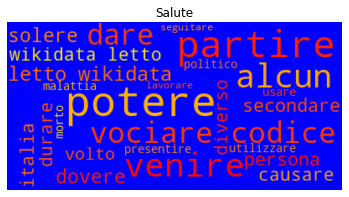

In [39]:
wordcloud = WordCloud(max_font_size=50, max_words=25, background_color='blue', colormap='autumn')
wordcloud.generate(salute)

plt.figure()
plt.title("Salute")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

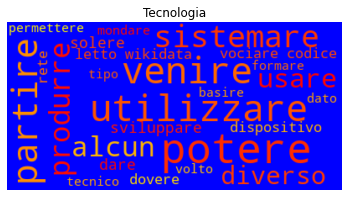

In [40]:
wordcloud = WordCloud(max_font_size=50, max_words=25, background_color='blue', colormap='autumn')
wordcloud.generate(tecnologia)

plt.figure()
plt.title("Tecnologia")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

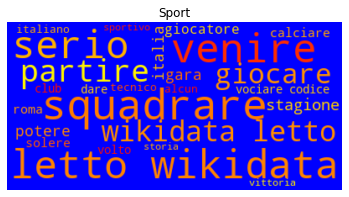

In [41]:
wordcloud = WordCloud(max_font_size=50, max_words=25, background_color='blue', colormap='autumn')
wordcloud.generate(sport)

plt.figure()
plt.title("Sport")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

##### Spiegazione

In [43]:
cv_esempio = CountVectorizer()

In [44]:
testo_prova = "primo testo di prova"
testo_test = "secondo testo di prova"

In [45]:
cv_esempio.fit(testo_prova.split(" "))

cv_esempio.get_feature_names()

['di', 'primo', 'prova', 'testo']

In [46]:
print(testo_prova)

cv_esempio.transform(testo_prova.split(" ")).toarray()

primo testo di prova


array([[0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0]])

In [47]:
print(testo_test)

cv_esempio.transform(testo_test.split(" ")).toarray()

secondo testo di prova


array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 1, 0]])

In [48]:
np.max(cv_esempio.transform(testo_test.split(" ")).toarray(), axis=0)

array([1, 0, 1, 1])

In [49]:
df = pd.DataFrame(data = np.max(cv_esempio.transform(testo_test.split(" ")).toarray(), axis=0).reshape((1,4)), \
                  columns=cv_esempio.get_feature_names())
df

,di,primo,prova,testo
0,1,0,1,1


In [55]:
vocab = Vocabulary('vocab.json', tokens = True)
vocab.import_stopwords("stopwords_ita.txt")

Sono stati caricati n.81039 elementi
Dopo la riduzione ci sono n.18101 elementi


##### Applicazione

In [52]:
cv = CountVectorizer(vocabulary = vocab.word2idx)

In [53]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

classes = labelencoder.fit_transform(['salute','tecnologia','sport'])
classes = classes.tolist()
classes

[0, 2, 1]

In [54]:
labelencoder.transform(['salute'])[0]

0

In [159]:
def preparazione_dati(articolo):

        estrati_dati(articolo)

        dati = estrati_dati(articolo)
                
        y = dati[1]
        
        y = labelencoder.transform([y])[0]

        doc = nlp(dati[0])
        
        """
        Esclude le parole che sono stopwords e trasforma in OOV le parole non comprese nel vocabolario
        """

        tokens = [token.lemma_ if token.lemma_ in vocab.word2idx.keys() else 'OOV' for token in doc if not (token.lemma_ in vocab.stopwords)]

        testo = ""

        for token in tokens:
           
            testo += " " + token
            
        X = cv.transform(testo.split()).toarray()
        X = np.max(X, axis=0).tolist()
        
        return X, y

In [160]:
articoli = iter(glob.glob("archivio/*.txt"))

In [161]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier(fit_intercept=False)

In [162]:
arr_X, arr_y = [], []

i = 0
batch_size = 64

while True:
    
    
    try:
        
        i += 1
        
        if i > 1024:
            raise StopIteration

        articolo = next(articoli)
        risp = preparazione_dati(articolo)

        arr_X.append(risp[0])
        arr_y.append(risp[1]) 

        if i % batch_size == 0:

            classifier.partial_fit(arr_X, arr_y, classes)

            arr_X, arr_y = [], []
                    
    except StopIteration:
        print("Fine")
        break


Fine


##### Qualche dettaglio sul classificatore

In [163]:
labelencoder.transform(['salute'])[0]

0

In [164]:
print(len(classifier.coef_[0]))
print(len(vocab.idx2word))

18101
18101


In [165]:
# Valore max
np.max(classifier.coef_[0])

79.09045971329701

In [166]:
# Indice della parola con valore max
indice = str(np.argmax(classifier.coef_[0]))
print(indice)

1559


In [167]:
# Parola con valore max
vocab.idx2word[indice]

'malattia'

In [190]:
tot = {k:v for k,v in zip(vocab.word2idx.keys(), classifier.coef_[0])}

In [191]:
tot_salute = {k:v for k,v in sorted(tot.items(), key=lambda item: item[1], reverse=True)}

In [192]:
df = pd.DataFrame()
df = df.from_dict(tot_salute, orient='index')

print(f"Prime 10 parole:\n {df.head(10)}\n\n")

print(f"Ultime 10 parole:\n {df.tail(10)}")

Prime 10 parole:
                      0
malattia     79.090460
sanitario    59.317845
sanità       54.374691
persona      54.374691
donna        54.374691
medical      54.374691
riguardare   49.431537
medicare     49.431537
prevenzione  49.431537
riferimento  44.488384


Ultime 10 parole:
                      0
impiegare   -49.431537
mercato     -49.431537
calciare    -54.374691
importare   -54.374691
tipo        -59.317845
lanciare    -59.317845
sportivo    -64.260999
tecnico     -74.147306
evoluzione  -79.090460
tecnologico -93.919921


In [79]:
# articoli = iter(glob.glob("archivio/*.txt"))

##### Vediamo cosa accade quando il classificatore tenta di prevedere la classe di appartenenza per il resto degli articoli

In [172]:
articolo = next(articoli)
risp = preparazione_dati(articolo)

In [173]:
# Classe di appartenenza dell'articolo
risp[1]

0

In [174]:
# Classe prevista dal classificatore
classifier.predict([risp[0]])[0]

0

In [175]:
n = 0
correct = 0
total = 0

while True:
    
    n += 1

    try:
        
        total += 1
        
        articolo = next(articoli)
        
        risp = preparazione_dati(articolo)
        
        """
        Costruzione manuale dell'accuracy
        """
        if risp[1] == classifier.predict([risp[0]])[0]:
            
            correct += 1
            
        if n % 100 == 0:
            print(f"partial {correct/total}")
            
                
    except StopIteration:
        print(f"Fine: {correct/total}")
        break

partial 0.87
partial 0.865
partial 0.87
partial 0.875
Fine: 0.8636363636363636
